# **Встановлення бібліотек**

In [ ]:
!pip install yfinance
!pip install pmdarima
!pip install pandas
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00


# **Імпорт бібліотек**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.arima import ndiffs
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from prophet import Prophet

# **Збирання та форматування даних**

In [ ]:
# Завантаження даних для Apple з 2010 року
ticker = "AAPL"  # Встановлюємо тікер для акцій Apple
data = yf.download(ticker, start='2010-01-01').reset_index()  # Завантажуємо дані за допомогою yfinance і скидаємо індекс
data = data[['Close', 'Date']].rename(columns={'Close': 'rate', 'Date': 'date'})  # Вибираємо колонки 'Close' і 'Date', перейменовуємо для зручності

# Розділення на навчальні і тестові дані
train_size = int(len(data) * 0.95)  # Визначаємо розмір навчальної вибірки (95% від загального обсягу)
df_train = data.iloc[:train_size]
df_test = data.iloc[train_size:]

[*********************100%***********************]  1 of 1 completed


## **Візуалізація зібраних даних**

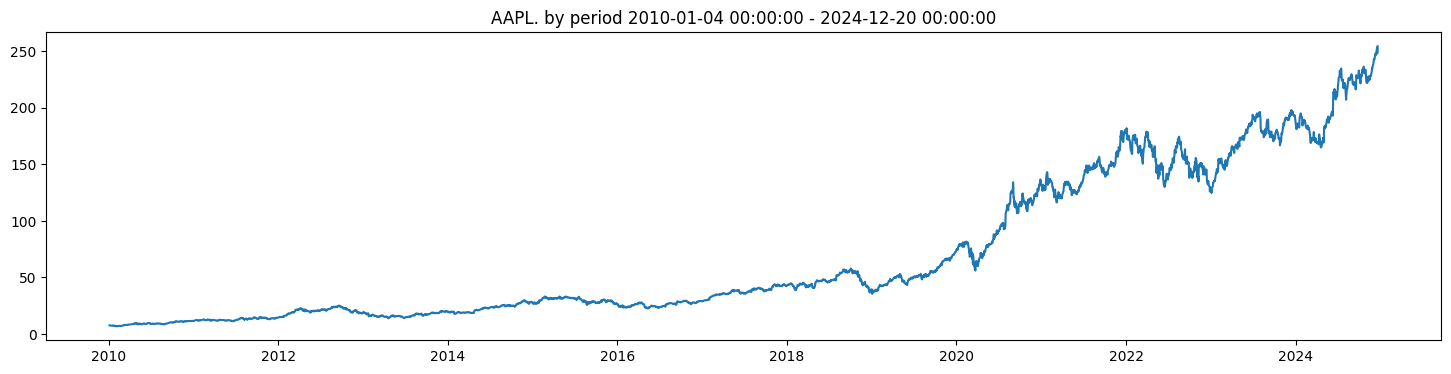

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(data['date'], data['rate'])  # Будуємо графік для колонки 'rate' відносно 'date'
plt.title(f'{ticker}. by period {min(data.date)} - {max(data.date)}')
plt.show()

## **Візуалізація тестових та тренувальних даних**

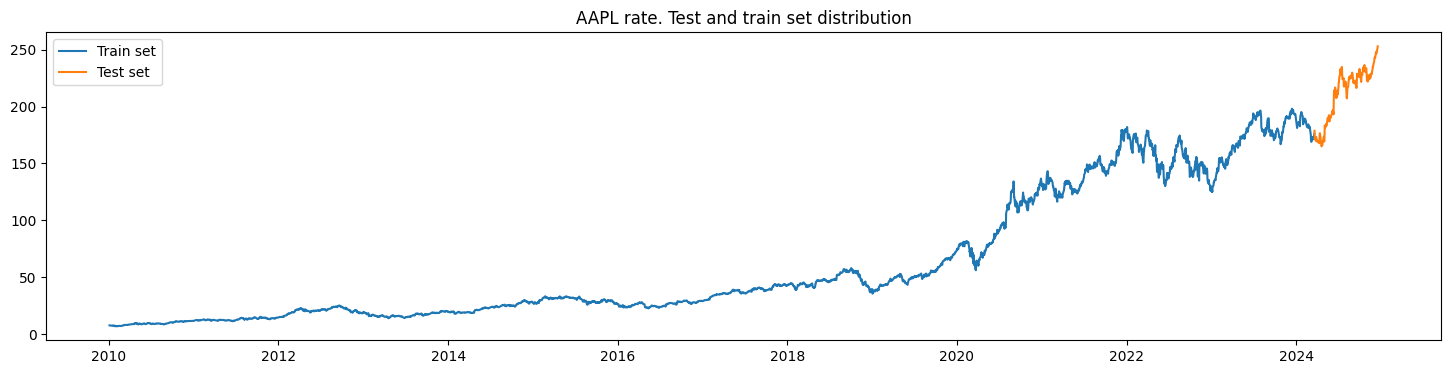

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df_train['date'], df_train['rate'], label='Train set')
ax.plot(df_test['date'], df_test['rate'], label='Test set')
ax.legend()
plt.title(f'{ticker} rate. Test and train set distribution')
plt.show()

# **Використання ARIMA для визначення оптимальних лагів**

In [ ]:
# Визначення кількості диференціювань для ARIMA
adf_diffs = ndiffs(df_train['rate'], alpha=0.05, test='adf', max_d=6)  # Тест Дікі-Фуллера для визначення кількості диференціювань
kpss_diffs = ndiffs(df_train['rate'], alpha=0.05, test='kpss', max_d=6)  # Тест KPSS для визначення кількості диференціювань
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Optimal number of differences: {n_diffs}")

Optimal number of differences: 1


In [ ]:
# Ініціалізація ARIMA моделі з автоматичним підбором параметрів
model = auto_arima(df_train.rate,      # Цільова змінна: ряд для навчання
                   d=n_diffs,          # Параметр диференціювання для стаціонарності
                   seasonal=False,     # Вимикаємо сезонність (якщо потрібно сезонність, встановіть True)
                   suppress_warnings=True,  # Вимикає попередження під час роботи
                   error_action="ignore",   # Ігнорує можливі помилки у процесі підбору
                   max_p=6,            # Максимальне значення для параметра p (авторегресивний порядок)
                   max_order=None,     # Не обмежує сумарний порядок моделі (p+q)
                   trace=False         # Вимикає виведення проміжних результатів підбору параметрів
                   )

In [ ]:
# Функція для прогнозування одного кроку вперед
def forecast_one_step(model):
    """
    Виконує прогноз на 1 крок вперед і повертає значення прогнозу та довірчий інтервал.

    Returns:
    - fc (float): Прогнозоване значення.
    - conf_int (list): Довірчий інтервал для прогнозу.
    """
    fc, conf_int = model.predict(n_periods=1,
                                 return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [ ]:
# Списки для збереження прогнозованих значень та довірчих інтервалів
y_predict_day_by_day = []
y_confidence = []

# Цикл для послідовного прогнозування та оновлення моделі
for i, new_ob in enumerate(df_test.rate.values):  # Ітеруємо по всім значенням тестового набору
    fc, conf = forecast_one_step(model=model)  # Виконуємо прогноз на один крок вперед
    y_predict_day_by_day.append(fc)  # Додаємо прогнозоване значення до списку
    y_confidence.append(conf)        # Додаємо довірчий інтервал до списку

    model.update(new_ob)  # Оновлюємо ARIMA модель новим спостереженням з тестових даних

## **Візуалізація передбачених значень**

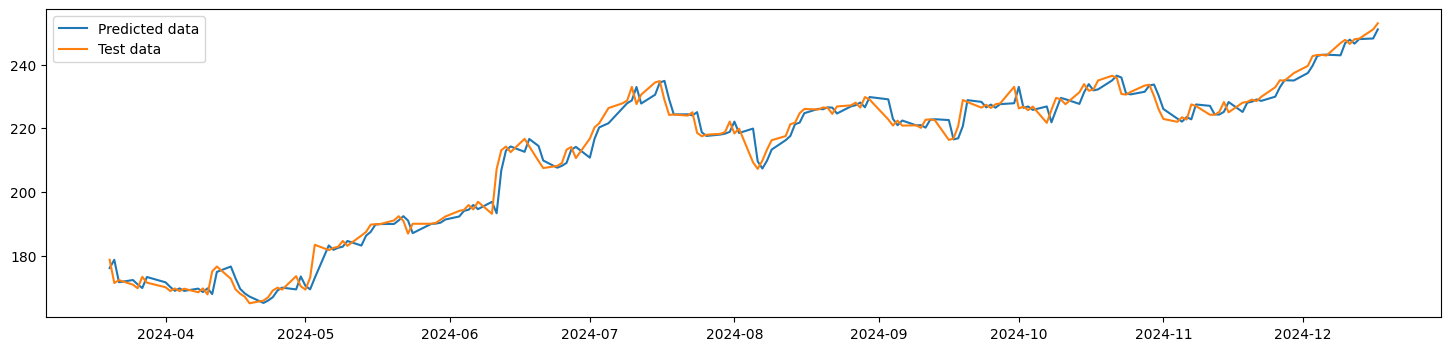

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df_test['date'], y_predict_day_by_day, label='Predicted data')
ax.plot(df_test['date'], df_test['rate'], label='Test data')
ax.legend()
plt.show()

# **SARIMA**

In [ ]:
model_sarima = auto_arima(df_train.rate,  # Цільова змінна для навчання
                     d=n_diffs,          # Кількість диференціювань для досягнення стаціонарності
                     seasonal=True,      # Увімкнено сезонну компоненту
                     m=3,                # Сезонний період (наприклад, 3 для квартальних даних)
                     stepwise=True,      # Покроковий підбір параметрів для прискорення обчислень
                     suppress_warnings=True,  # Вимикає попередження під час навчання моделі
                     error_action="ignore",   # Ігнорує помилки в процесі підбору параметрів
                     max_p=6,            # Максимальне значення для параметра p (авторегресивний порядок)
                     max_order=None,     # Не обмежує сумарний порядок моделі (p+q)
                     trace=False         # Вимикає вивід процесу підбору параметрів
                     )

In [ ]:
# Списки для збереження прогнозованих значень та довірчих інтервалів
y_predict_day_by_day_sarima = []
y_confidence = []

# Цикл для послідовного прогнозування та оновлення моделі
for i, new_ob in enumerate(df_test.rate.values):  # Ітеруємо по всім значенням тестового набору
    fc, conf = forecast_one_step(model=model_sarima)  # Виконуємо прогноз на один крок вперед
    y_predict_day_by_day_sarima.append(fc)  # Додаємо прогнозоване значення до списку
    y_confidence.append(conf)        # Додаємо довірчий інтервал до списку

    model_sarima.update(new_ob)  # Оновлюємо SARIMA модель новим спостереженням з тестових даних

## **Візуалізація передбачених значень**

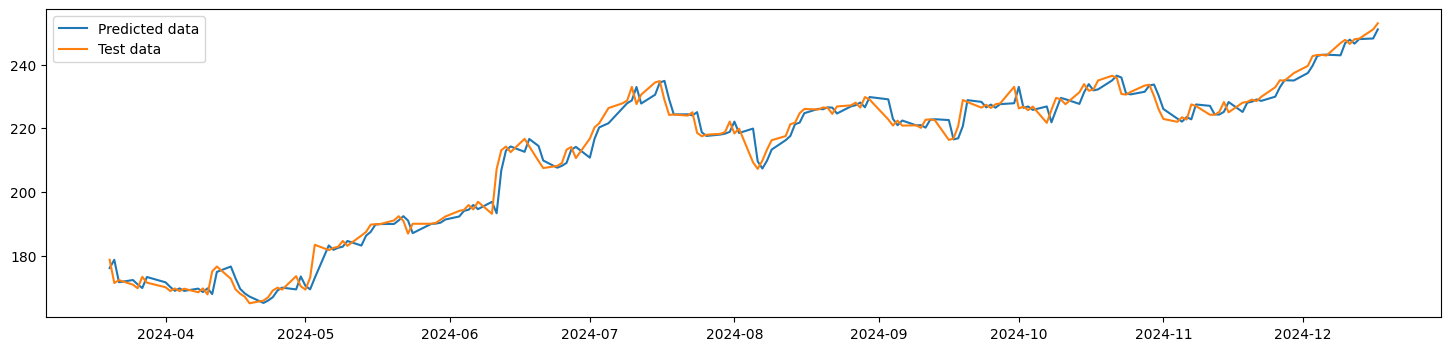

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df_test['date'], y_predict_day_by_day_sarima, label='Predicted data')
ax.plot(df_test['date'], df_test['rate'], label='Test data')
ax.legend()
plt.show()

# **Всі моделі окрім ARIMA і SARIMA (сезонна ARIMA)**

## **GRU**

In [ ]:
def train_gru(X_train, y_train, seq_length):
    """
    Тренування GRU-моделі для прогнозування часових рядів.

    Parameters:
    - X_train (numpy array): Навчальний набір даних у форматі 3D (samples, time_steps, features).
    - y_train (numpy array): Цільові значення для навчання.
    - seq_length (int): Довжина часової послідовності (кількість попередніх кроків для прогнозування).

    Returns:
    - model (Sequential): Навчена GRU-модель.
    """
    # Ініціалізація моделі
    model = Sequential([
        GRU(50, activation='relu', input_shape=(seq_length, 1)),  # GRU-шар з 50 нейронами та функцією активації 'relu'
        Dense(1)  # Вихідний шар з одним нейроном для прогнозування одного значення
    ])

    # Компіляція моделі з оптимізатором 'adam' та функцією втрат 'mse'
    model.compile(optimizer='adam', loss='mse')

    # Навчання моделі
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

    return model


def predict_gru(model, X_test, scaler):
    """
    Прогнозування на основі навченої GRU-моделі з денормалізацією результатів.

    Parameters:
    - model (Sequential): Навчена GRU-модель.
    - X_test (numpy array): Тестові дані у форматі 3D (samples, time_steps, features).
    - scaler (MinMaxScaler): Масштабувальник, який використовувався для нормалізації навчальних даних.

    Returns:
    - predictions (numpy array): Денормалізовані прогнозовані значення у форматі 1D.
    """
    # Виконання прогнозу на тестових даних
    predictions = model.predict(X_test)

    # Денормалізація прогнозованих значень за допомогою масштабувальника
    return scaler.inverse_transform(predictions).flatten()  # Перетворюємо назад у початковий масштаб та "сплющуємо" у 1D

## **LSTM**

In [ ]:
def train_lstm(X_train, y_train, seq_length):
    """
    Тренування LSTM-моделі для прогнозування часових рядів.

    Parameters:
    - X_train (numpy array): Навчальний набір даних у форматі 3D (samples, time_steps, features).
    - y_train (numpy array): Цільові значення для навчання.
    - seq_length (int): Довжина часової послідовності (кількість попередніх кроків часу для прогнозу).

    Returns:
    - model (Sequential): Навчена LSTM-модель.
    """
    # Ініціалізація нейронної мережі
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),  # Додаємо LSTM-шар з 50 нейронами і ReLU активацією
        Dense(1)  # Вихідний шар з одним нейроном для прогнозування одного значення
    ])

    # Компіляція моделі з оптимізатором 'adam' та функцією втрат 'mse'
    model.compile(optimizer='adam', loss='mse')  # Adam – ефективний оптимізатор, MSE – функція втрат для регресії

    # Навчання моделі на навчальних даних
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    # epochs=20: кількість ітерацій по всьому набору даних
    # batch_size=16: розмір підвибірки даних на одну ітерацію

    return model


def predict_lstm(model, X_test, scaler):
    """
    Виконує прогнозування за допомогою навченої LSTM-моделі та денормалізує результати.

    Parameters:
    - model (Sequential): Навчена LSTM-модель.
    - X_test (numpy array): Тестовий набір даних у форматі 3D (samples, time_steps, features).
    - scaler (MinMaxScaler): Масштабувальник, що використовувався для нормалізації даних.

    Returns:
    - numpy array: Денормалізовані прогнозовані значення у форматі 1D.
    """
    # Виконання прогнозування на тестових даних
    predictions = model.predict(X_test)  # Генеруємо прогнозовані значення

    # Денормалізація прогнозів, щоб повернути їх у початковий масштаб
    return scaler.inverse_transform(predictions).flatten()

## **Gradient Boosting Regressor**

In [ ]:
def train_gradient_boosting(X_train, y_train):
    """
    Тренування Gradient Boosting Regressor для прогнозування часових рядів.

    Parameters:
    - X_train (DataFrame or numpy array): Матриця ознак для навчання моделі.
    - y_train (Series or numpy array): Цільові значення для навчання.

    Returns:
    - model (GradientBoostingRegressor): Навчена модель Gradient Boosting.
    """
    # Ініціалізація моделі Gradient Boosting Regressor
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    # n_estimators=100: кількість дерев у ансамблі
    # random_state=42: фіксований генератор випадкових чисел для відтворюваності результату

    # Навчання моделі на основі навчальних даних
    model.fit(X_train, y_train)

    return model


def predict_gradient_boosting(model, X_test):
    """
    Прогнозування значень на основі навченої моделі Gradient Boosting.

    Parameters:
    - model (GradientBoostingRegressor): Навчена модель Gradient Boosting.
    - X_test (DataFrame or numpy array): Тестові дані (матриця ознак) для прогнозування.

    Returns:
    - numpy array: Масив прогнозованих значень.
    """
    return model.predict(X_test)

## **Random Forest**

In [ ]:
def train_random_forest(X_train, y_train):
    """
    Тренування моделі Random Forest для прогнозування часових рядів.

    Parameters:
    - X_train (DataFrame or numpy array): Матриця ознак для навчання.
    - y_train (Series or numpy array): Цільові значення для навчання.

    Returns:
    - model (RandomForestRegressor): Навчена модель Random Forest.
    """
    # Ініціалізація Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    # n_estimators=100: кількість дерев у лісі (більше значення — краща стабільність, але більше обчислень)
    # random_state=42: фіксує випадковий генератор для відтворюваності результатів

    # Навчання моделі на навчальних даних
    model.fit(X_train, y_train)  # Підгонка моделі до навчальних даних (X_train: ознаки, y_train: цільова змінна)

    return model


def predict_random_forest(model, X_test):
    """
    Прогнозування значень на основі навченої моделі Random Forest.

    Parameters:
    - model (RandomForestRegressor): Навчена модель Random Forest.
    - X_test (DataFrame or numpy array): Тестові дані для прогнозування.

    Returns:
    - numpy array: Масив прогнозованих значень.
    """
    return model.predict(X_test)

## **Prophet**

In [ ]:
def train_prophet(df_train):
    """
    Тренування моделі Prophet для прогнозування часових рядів.

    Parameters:
    - df_train (DataFrame): Навчальний набір даних з колонками 'date' і 'rate'.

    Returns:
    - model (Prophet): Навчена модель Prophet.
    """
    # Підготовка даних для Prophet: перетворюємо формат даних
    df_train_prophet = df_train.reset_index()[['date', 'rate']]  # Скидаємо індекс та вибираємо потрібні колонки
    df_train_prophet.columns = ['ds', 'y']  # Prophet вимагає назви колонок: 'ds' (дата) та 'y' (значення)

    # Ініціалізація та навчання моделі Prophet
    model = Prophet()
    model.fit(df_train_prophet)

    return model


def predict_prophet(model, df_test, y_test_ml):
    """
    Виконує прогнозування за допомогою навченої моделі Prophet.

    Parameters:
    - model (Prophet): Навчена модель Prophet.
    - df_test (DataFrame): Тестовий набір даних з індексом, що містить дати для прогнозу.

    Returns:
    - prophet_forecast (numpy array): Прогнозовані значення (yhat) для тестового набору даних.
    """
    # Створення датафрейму для майбутніх прогнозів на основі дат із тестового набору
    future = pd.DataFrame(df_test.index, columns=['ds'])  # Створюємо датафрейм із датами для прогнозування

    # Генеруємо майбутній датафрейм на вказану кількість періодів
    future = model.make_future_dataframe(periods=len(df_test))  # Додаємо періоди для тестових даних

    # Виконання прогнозування
    forecast_prophet = model.predict(future)

    # Вибираємо останні прогнозовані значення (yhat), що відповідають тестовому набору
    prophet_forecast = forecast_prophet['yhat'].tail(len(y_test_ml)).values

    return prophet_forecast

In [ ]:
def create_lag_features(data, lags=3):
    """
    Створює лагові ознаки для часових рядів.

    Parameters:
    - data (DataFrame): Вхідний датафрейм з колонкою 'rate'.
    - lags (int): Кількість лагів, які потрібно створити.

    Returns:
    - DataFrame: Датафрейм з доданими лаговими ознаками.
    """
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['rate'].shift(lag)  # Створюємо лагову ознаку для кожного лагу
    return data

In [ ]:
def create_sequences(data, seq_length):
    """
    Створює послідовності для навчання моделей LSTM/GRU.

    Parameters:
    - data (numpy array): Масштабовані дані у форматі numpy array.
    - seq_length (int): Довжина послідовності.

    Returns:
    - X, y: Масиви для навчання у форматі (samples, time_steps, features).
    """
    X, y = [], []
    for i in range(len(data) - seq_length):  # Цикл по всім можливим послідовностям
        X.append(data[i:i+seq_length, 0])  # Додаємо вхідну послідовність
        y.append(data[i+seq_length, 0])  # Додаємо цільове значення
    return np.array(X), np.array(y)

# **Передбачення**

In [ ]:
# Створення лагових ознак для навчального набору
df_train_ml = create_lag_features(df_train.copy())  # Створюємо лагові ознаки для навчальної вибірки
df_train_ml.dropna(inplace=True)  # Видаляємо рядки з відсутніми значеннями

# Розділяємо навчальні дані на ознаки (X) та цільову змінну (y)
X_train_ml = df_train_ml[[f'lag_{i}' for i in range(1, 4)]]  # Вибираємо лагові ознаки (lag_1, lag_2, lag_3)
y_train_ml = df_train_ml['rate']  # Цільова змінна – колонка 'rate'

# Створення лагових ознак для тестового набору
df_test_ml = create_lag_features(df_test.copy())  # Створюємо лагові ознаки для тестової вибірки
X_test_ml = df_test_ml[[f'lag_{i}' for i in range(1, 4)]].dropna()  # Вибираємо лагові ознаки та видаляємо відсутні значення
y_test_ml = df_test_ml['rate'][3:]  # Цільова змінна для тестового набору (пропускаємо перші 3 значення через лаги)
# Навчання Random Forest на навчальних даних
rf_model = train_random_forest(X_train_ml, y_train_ml)

# Прогнозування на тестових даних
rf_forecast = predict_random_forest(rf_model, X_test_ml)
# Навчання моделі Prophet на навчальних даних
prophet_model = train_prophet(df_train)

# Прогнозування на тестових даних
prophet_forecast = predict_prophet(prophet_model, df_test, y_test_ml)
# Навчання Gradient Boosting на навчальних даних
gb_model = train_gradient_boosting(X_train_ml, y_train_ml)

# Прогнозування на тестових даних
gb_forecast = predict_gradient_boosting(gb_model, X_test_ml)
# Масштабування навчального та тестового наборів
scaler = MinMaxScaler()  # Ініціалізуємо MinMaxScaler для нормалізації даних
train_scaled = scaler.fit_transform(df_train[['rate']])
test_scaled = scaler.transform(df_test[['rate']])
seq_length = 3

# Створюємо послідовності для навчальних даних
X_train_dl, y_train_dl = create_sequences(train_scaled, seq_length)

# Створюємо послідовності для тестових даних
X_test_dl, y_test_dl = create_sequences(test_scaled, seq_length)

# Зміна форми даних на (samples, time_steps, features) для LSTM/GRU
X_train_dl = X_train_dl.reshape(X_train_dl.shape[0], X_train_dl.shape[1], 1)
X_test_dl = X_test_dl.reshape(X_test_dl.shape[0], X_test_dl.shape[1], 1)
# Навчання LSTM-моделі
lstm_model = train_lstm(X_train_dl, y_train_dl, seq_length)

# Прогнозування на тестових даних
lstm_forecast = predict_lstm(lstm_model, X_test_dl, scaler)
# Навчання GRU-моделі
gru_model = train_gru(X_train_dl, y_train_dl, seq_length)

# Прогнозування на тестових даних
gru_forecast = predict_gru(gru_model, X_test_dl, scaler)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpldb7api2/uvhjoco6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpldb7api2/nxg8cb91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82317', 'data', 'file=/tmp/tmpldb7api2/uvhjoco6.json', 'init=/tmp/tmpldb7api2/nxg8cb91.json', 'output', 'file=/tmp/tmpldb7api2/prophet_modelsxws16xv/prophet_model-20241217172923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:C

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Prophet RMSE: 32.33
Random Forest RMSE: 25.74
Gradient Boosting RMSE: 25.63
LSTM RMSE: 4.05
GRU RMSE: 5.80


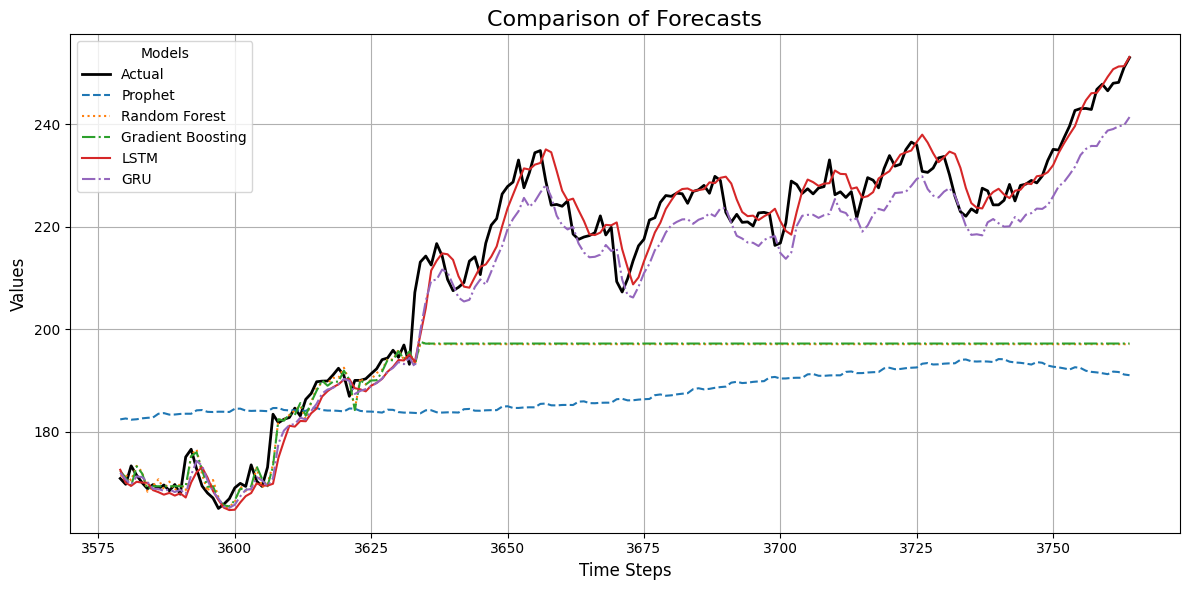

In [ ]:
# Обчислення RMSE (Root Mean Square Error) для кожної моделі
rmse_values = {
    "Prophet": np.sqrt(mean_squared_error(y_test_ml, prophet_forecast)),
    "Random Forest": np.sqrt(mean_squared_error(y_test_ml, rf_forecast)),
    "Gradient Boosting": np.sqrt(mean_squared_error(y_test_ml, gb_forecast)),
    "LSTM": np.sqrt(mean_squared_error(y_test_ml, lstm_forecast)),
    "GRU": np.sqrt(mean_squared_error(y_test_ml, gru_forecast))
}

# Побудова графіків для порівняння фактичних даних і прогнозів різних моделей
plt.figure(figsize=(12, 6))

# Побудова графіка фактичних значень
plt.plot(y_test_ml.index, y_test_ml, label="Actual", color="black", linewidth=2)

# Побудова графіків прогнозів для кожної моделі
plt.plot(y_test_ml.index, prophet_forecast, label="Prophet", linestyle="--")  # Прогноз Prophet (пунктирна лінія)
plt.plot(y_test_ml.index, rf_forecast, label="Random Forest", linestyle=":")  # Прогноз Random Forest (крапкова лінія)
plt.plot(y_test_ml.index, gb_forecast, label="Gradient Boosting", linestyle="-.")  # Прогноз Gradient Boosting (штрих-пунктирна лінія)
plt.plot(y_test_ml.index, lstm_forecast, label="LSTM", linestyle="solid")  # Прогноз LSTM (суцільна лінія)
plt.plot(y_test_ml.index, gru_forecast, label="GRU", linestyle="dashdot")  # Прогноз GRU (штрих-крапкова лінія)

# Додавання налаштувань графіка
plt.title("Comparison of Forecasts", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(title="Models", fontsize=10)
plt.grid(True)

# Виведення значень RMSE для кожної моделі
for model, rmse in rmse_values.items():
    print(f"{model} RMSE: {rmse:.2f}")

# Налаштування для коректного відображення графіка
plt.tight_layout()  # Автоматичне налаштування підписів і елементів графіка для уникнення перекриття
plt.show()